### Train PCA for NMF-based SFH model

The actually training for PCA is done using `popsed/script/gen_sed/NMF/train_PCA.py`. Below we validate the trained PCA models, and make figure for the paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')

In [4]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
# from popsed import mock
from popsed.speculator import SpectrumPCA
from scipy.stats import norm

In [15]:
# kuaizi: under master branch
import popsed
popsed.set_matplotlib(style='JL', usetex=True)

Now we have 10 params: 4+2 SFH (but actually 3+2) + 1 tage + 1 logzsol + 3 dusts

Load validation dataset (slow)

In [7]:
wave = np.load('./train_sed_NMF_ZH/nmf_zh_seds/fsps.wavelength.npy')

In [8]:
log_spec = np.zeros((int(1e5), len(wave)))
log_spec_in_basis = np.zeros((int(1e5), len(wave)))

for i_bin in range(5):
    wave_bin = [ 
            (wave >= 1000) & (wave < 2000), 
            (wave >= 2000) & (wave < 3600), 
            (wave >= 3600) & (wave < 5500), 
            (wave >= 5500) & (wave < 7410), 
            (wave >= 7410) & (wave < 60000)
            ][i_bin]
    str_wbin = [
            '.w1000_2000', 
            '.w2000_3600', 
            '.w3600_5500', 
            '.w5500_7410', 
            '.w7410_60000' 
            ][i_bin]

    with open(f'./train_sed_NMF_ZH/nmf_zh_seds/fsps.NMF_ZH.pca_trained{str_wbin}.pkl', 'rb') as f:
        pca = pickle.load(f)

    log_spec[:, wave_bin], log_spec_in_basis[:, wave_bin] = pca.validate_pca_basis(
        f'./train_sed_NMF_ZH/nmf_zh_seds/fsps.NMF_ZH.v0.2.log10spectrum.seedtest{str_wbin}.npy'
    )

In [9]:
# also slow
diff = (10**log_spec - 10**log_spec_in_basis) / 10**log_spec * 100

In [10]:
med_diff = np.median(diff, axis=0)
diff_1sigma = [np.percentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
               np.percentile(diff, norm.cdf(1) * 100, axis=0)]
diff_2sigma = [np.percentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
               np.percentile(diff, norm.cdf(2) * 100, axis=0)]

In [11]:
diff_3sigma = [np.percentile(diff, (1 - norm.cdf(3)) * 100, axis=0), 
               np.percentile(diff, norm.cdf(3) * 100, axis=0)]

In [12]:
import matplotlib.ticker as mtick

In [17]:
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=80, fontsize=15)

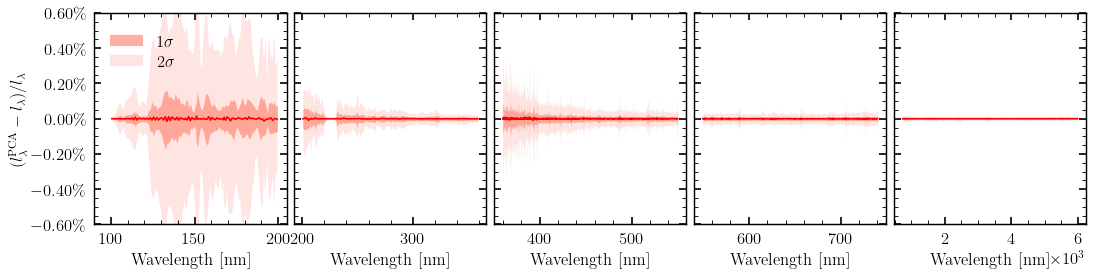

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(16, 3.5), sharey=True)

for i_bin in range(5):
    plt.sca(axes[i_bin])
    wave_bin = [ 
            (wave >= 1000) & (wave < 2000), 
            (wave >= 2000) & (wave < 3600), 
            (wave >= 3600) & (wave < 5500), 
            (wave >= 5500) & (wave < 7410), 
            (wave >= 7410) & (wave < 60000)
            ][i_bin]
    x = wave[wave_bin] / 10
    plt.plot(x, med_diff[wave_bin], color='r')
    plt.fill_between(x, 
                     diff_1sigma[0][wave_bin], 
                     diff_1sigma[1][wave_bin], 
                     alpha=0.5, lw=0.1, color='tomato', label='$1\sigma$')

    plt.fill_between(x, 
                     diff_2sigma[0][wave_bin], 
                     diff_2sigma[1][wave_bin], 
                     alpha=0.2, lw=0.1, color='salmon', label='$2\sigma$')
    plt.xlabel('Wavelength [nm]')
    plt.ylim(-0.6, 0.6)
    
axes[0].set_ylabel(r'$(l_{\lambda}^{\mathrm{PCA}} - l_{\lambda})/l_{\lambda}$')
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[0].legend(loc='upper left', bbox_to_anchor=(-0.03, 1.))
axes[0].set_xlim(90, 205)

plt.subplots_adjust(wspace=0.04)
# plt.savefig('/home/jiaxuanl/Research/popsed/figure/pca_accuracy.png')

Text(0.5, 0.98, 'PCA components')

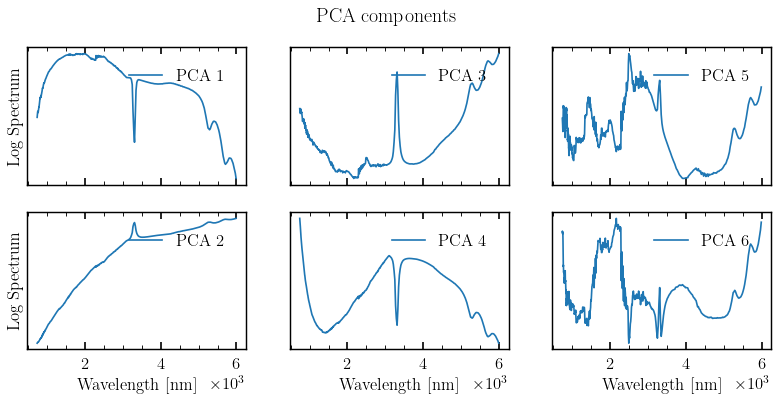

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5), sharex=True)

x = wave[wave_bin] / 10

for i in range(6):
    ax = axes[i % 2, i // 2]
    ax.plot(x, pca.PCA.components_[i], label=f'PCA {i + 1}')
    ax.set_yticks([])
    ax.legend(loc='upper right')

axes[0][0].set_ylabel('Log Spectrum')
axes[1][0].set_ylabel('Log Spectrum')

for k in range(3):
    axes[1][k].set_xlabel('Wavelength [nm]')
    
plt.suptitle('PCA components')